In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

2023-11-03 06:10:57.056062: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Pre processing img data 

In [2]:
train_dir = "Datasets/cifar-10-img/train"
test_dir = "Datasets/cifar-10-img/test"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

# here batch_size is the number of images in each batch
train_batch_size = 5000
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=train_batch_size,
    class_mode='categorical'
)
test_batch_size = 1000
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=test_batch_size,
    class_mode='categorical'
)

Found 40079 images belonging to 10 classes.
Found 9921 images belonging to 10 classes.


#### Selecting only first batch with 5000 images as train and test data

In [3]:
x_train, y_train =  train_generator[0]
x_test, y_test = test_generator[0]

print(len(x_train))
print(len(x_test))

5000
1000


#### a. Load in a pre-trained CNN model trained on a large dataset

In [4]:
# Load VGG16 without top layers
weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(32, 32, 3))

#### b. Freeze parameters (weights) in model’s lower convolutional layers

In [5]:
for layer in base_model.layers:
   layer.trainable = False

#### c. Add custom classifier with several layers of trainable parameters to model

In [6]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

#### d. Train classifier layers on training data available for task

In [7]:
# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
79/79 [==============================] - 10s 119ms/step - loss: 1.9530 - accuracy: 0.2880 - val_loss: 1.6006 - val_accuracy: 0.4470
Epoch 2/10
79/79 [==============================] - 9s 113ms/step - loss: 1.5765 - accuracy: 0.4372 - val_loss: 1.4799 - val_accuracy: 0.4570
Epoch 3/10
79/79 [==============================] - 9s 108ms/step - loss: 1.4546 - accuracy: 0.4854 - val_loss: 1.4637 - val_accuracy: 0.4790
Epoch 4/10
79/79 [==============================] - 9s 113ms/step - loss: 1.3586 - accuracy: 0.5148 - val_loss: 1.3521 - val_accuracy: 0.5110
Epoch 5/10
79/79 [==============================] - 9s 113ms/step - loss: 1.2805 - accuracy: 0.5414 - val_loss: 1.3299 - val_accuracy: 0.5250
Epoch 6/10
79/79 [==============================] - 9s 112ms/step - loss: 1.2203 - accuracy: 0.5698 - val_loss: 1.3169 - val_accuracy: 0.5310
Epoch 7/10
79/79 [==============================] - 9s 115ms/step - loss: 1.1837 - accuracy: 0.5808 - val_loss: 1.3618 - val_accuracy: 0.5180
Epoch

#### e. Fine-tune hyper parameters and unfreeze more layers as needed

In [8]:
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(32, 32, 3))
# freeze all layers first
for layer in base_model.layers:
   layer.trainable = False
# unfreeze last 4 layers of base model
for layer in base_model.layers[len(base_model.layers) - 4:]:
   layer.trainable = True
# fine-tuning hyper parameters
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# training fine tuned model
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
79/79 [==============================] - 52s 651ms/step - loss: 1.9810 - accuracy: 0.2466 - val_loss: 1.5456 - val_accuracy: 0.4270
Epoch 2/10
79/79 [==============================] - 51s 649ms/step - loss: 1.3616 - accuracy: 0.5026 - val_loss: 1.3817 - val_accuracy: 0.5110
Epoch 3/10
79/79 [==============================] - 48s 608ms/step - loss: 1.1024 - accuracy: 0.6130 - val_loss: 1.3000 - val_accuracy: 0.5650
Epoch 4/10
79/79 [==============================] - 48s 606ms/step - loss: 0.9341 - accuracy: 0.6676 - val_loss: 1.3958 - val_accuracy: 0.5780
Epoch 5/10
79/79 [==============================] - 47s 593ms/step - loss: 0.8194 - accuracy: 0.7188 - val_loss: 1.1362 - val_accuracy: 0.6280
Epoch 6/10
79/79 [==============================] - 48s 604ms/step - loss: 0.7217 - accuracy: 0.7490 - val_loss: 1.2076 - val_accuracy: 0.6320
Epoch 7/10
79/79 [==============================] - 48s 607ms/step - loss: 0.6066 - accuracy: 0.7964 - val_loss: 1.2179 - val_accuracy: 0.6490

In [10]:
import matplotlib.pyplot as plt
predicted_value = model.predict(x_test)

32/32 [==============================] - 2s 65ms/step


In [11]:
labels = list(test_generator.class_indices.keys())

Preditcted:  frog
Actual:  frog


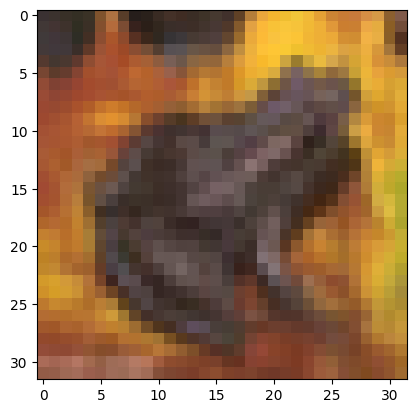

In [19]:
n = 890
plt.imshow(x_test[n])
print("Preditcted: ",labels[np.argmax(predicted_value[n])])
print("Actual: ", labels[np.argmax(y_test[n])])